In [1]:
import random
from collections import Counter
from os import path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mutual_info_score,
    normalized_mutual_info_score,
)
from sklearn.model_selection import train_test_split
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity, normalize
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch_geometric import utils
from torch_geometric.data import Batch, Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    BatchNorm,
    MessagePassing,
    dense_diff_pool,
    dense_mincut_pool,
    TopKPooling,
)
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx, to_undirected
from torch_scatter import scatter_mean

from dataset import GraphDataset, create_dataset
from utils import *

In [2]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)
        return (
            aggr_out,
            edge_index,
            batch,
            (attention_input, cross_graph_attention, a_x, a_y),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states

In [3]:
class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_pooling = TopKPooling(self.args.dim, ratio=8)
        self.topk_outputs = []

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):
        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (attention_input, cross_graph_attention, a_x, a_y),
            ) = self.layers[i](feats, edge_index, batch)
            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]
            x_pooled_1, edge_index_pooled_1, _, _, _, _ = self.topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, _, _ = self.topk_pooling(
                x_2,
                edge_index_2,
            )
            self.topk_outputs.append(
                ((x_pooled_1, edge_index_pooled_1), (x_pooled_2, edge_index_pooled_2))
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, x_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]
        return emb_1, emb_2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

Total number of graphs: 120
Number of classes: 4
Number of node features: 12
Average number of nodes per graph: 10
Max number of nodes in a graph: 11
Min number of nodes in a graph: 9
Class distribution:
 - Class 1: 30 graphs (25.00%)
 - Class 0: 30 graphs (25.00%)
 - Class 2: 30 graphs (25.00%)
 - Class 3: 30 graphs (25.00%)


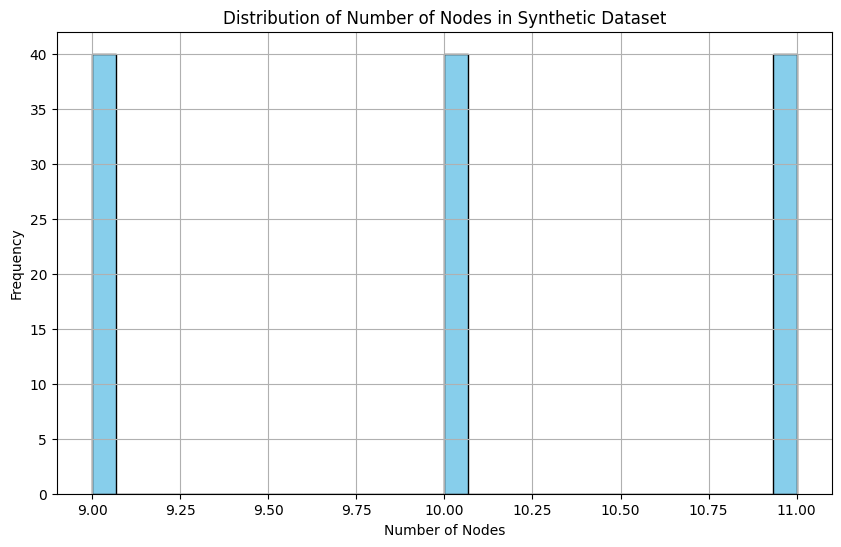

Small graphs: 120
Medium graphs: 0
Large graphs: 0


In [4]:
# dataset = TUDataset(
#     root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
# )

dataset = GraphDataset(torch.load("data/cycle_line_star_complete_n2v.pt"))

small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset)

In [5]:
class Args:
    def __init__(self):
        self.dim = 32
        self.feat_dim = dataset.num_features
        self.num_layers = 4
        self.margin = 0.3
        self.lr = 0.01
        self.n_classes = dataset.num_classes
        self.batch_size = 32
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = 2000


args = Args()

pairs, labels = create_graph_pairs(dataset, args.num_pairs)
pair_dataset = [(pair, label) for pair, label in zip(pairs, labels)]
train_loader = DataLoader(
    pair_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    collate_fn=collate_graph_pairs,
)

In [6]:
def train(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    def get_params(model):
        return {name: param.clone() for name, param in model.named_parameters()}

    initial_params = get_params(model)

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2 = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % args.batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            if i % 100 * args.batch_size == 0:
                print(
                    f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
                )

    trained_params = get_params(model)

    # for name in initial_params:
    #     initial_param = initial_params[name]
    #     trained_param = trained_params[name]
    #     if not torch.equal(initial_param, trained_param):
    #         print(f"Parameter {name} has changed.")
    #     else:
    #         print(f"Parameter {name} has NOT changed.")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

Epoch: 800 - Loss: 0.1089, Acc: 0.7812
Epoch: 1600 - Loss: 0.1281, Acc: 0.8750


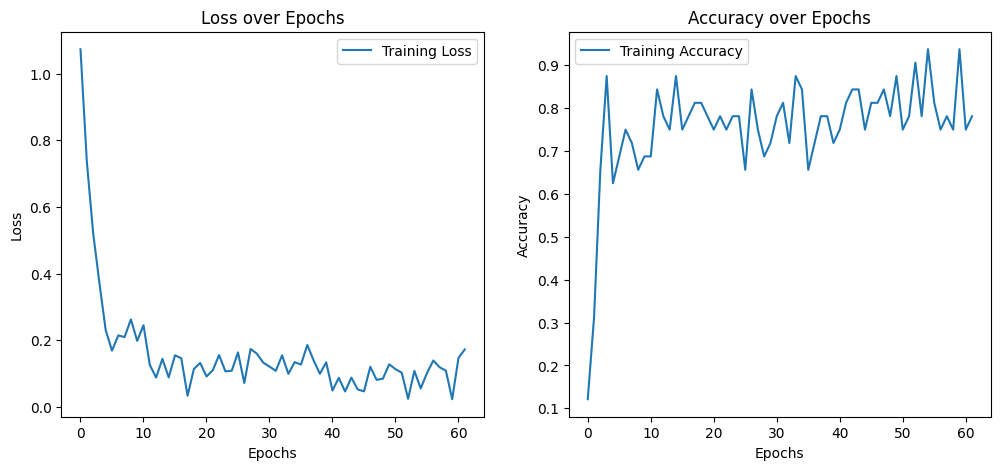

In [7]:
model = GraphMatchingNetwork(args).to(args.device)
optimizer = Adam(model.parameters(), lr=args.lr)

filename = f"checkpoints/checkpoint_{dataset.name.lower()}_{str(args.dim)}_pair.pth"

if path.exists(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(args.device)
    model.to(args.device)
else:
    train(model, train_loader, optimizer, args.device)
    # torch.save(
    #     {
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict(),
    #     },
    #     filename,
    # )

Label: 1
Similariy:  0.9959


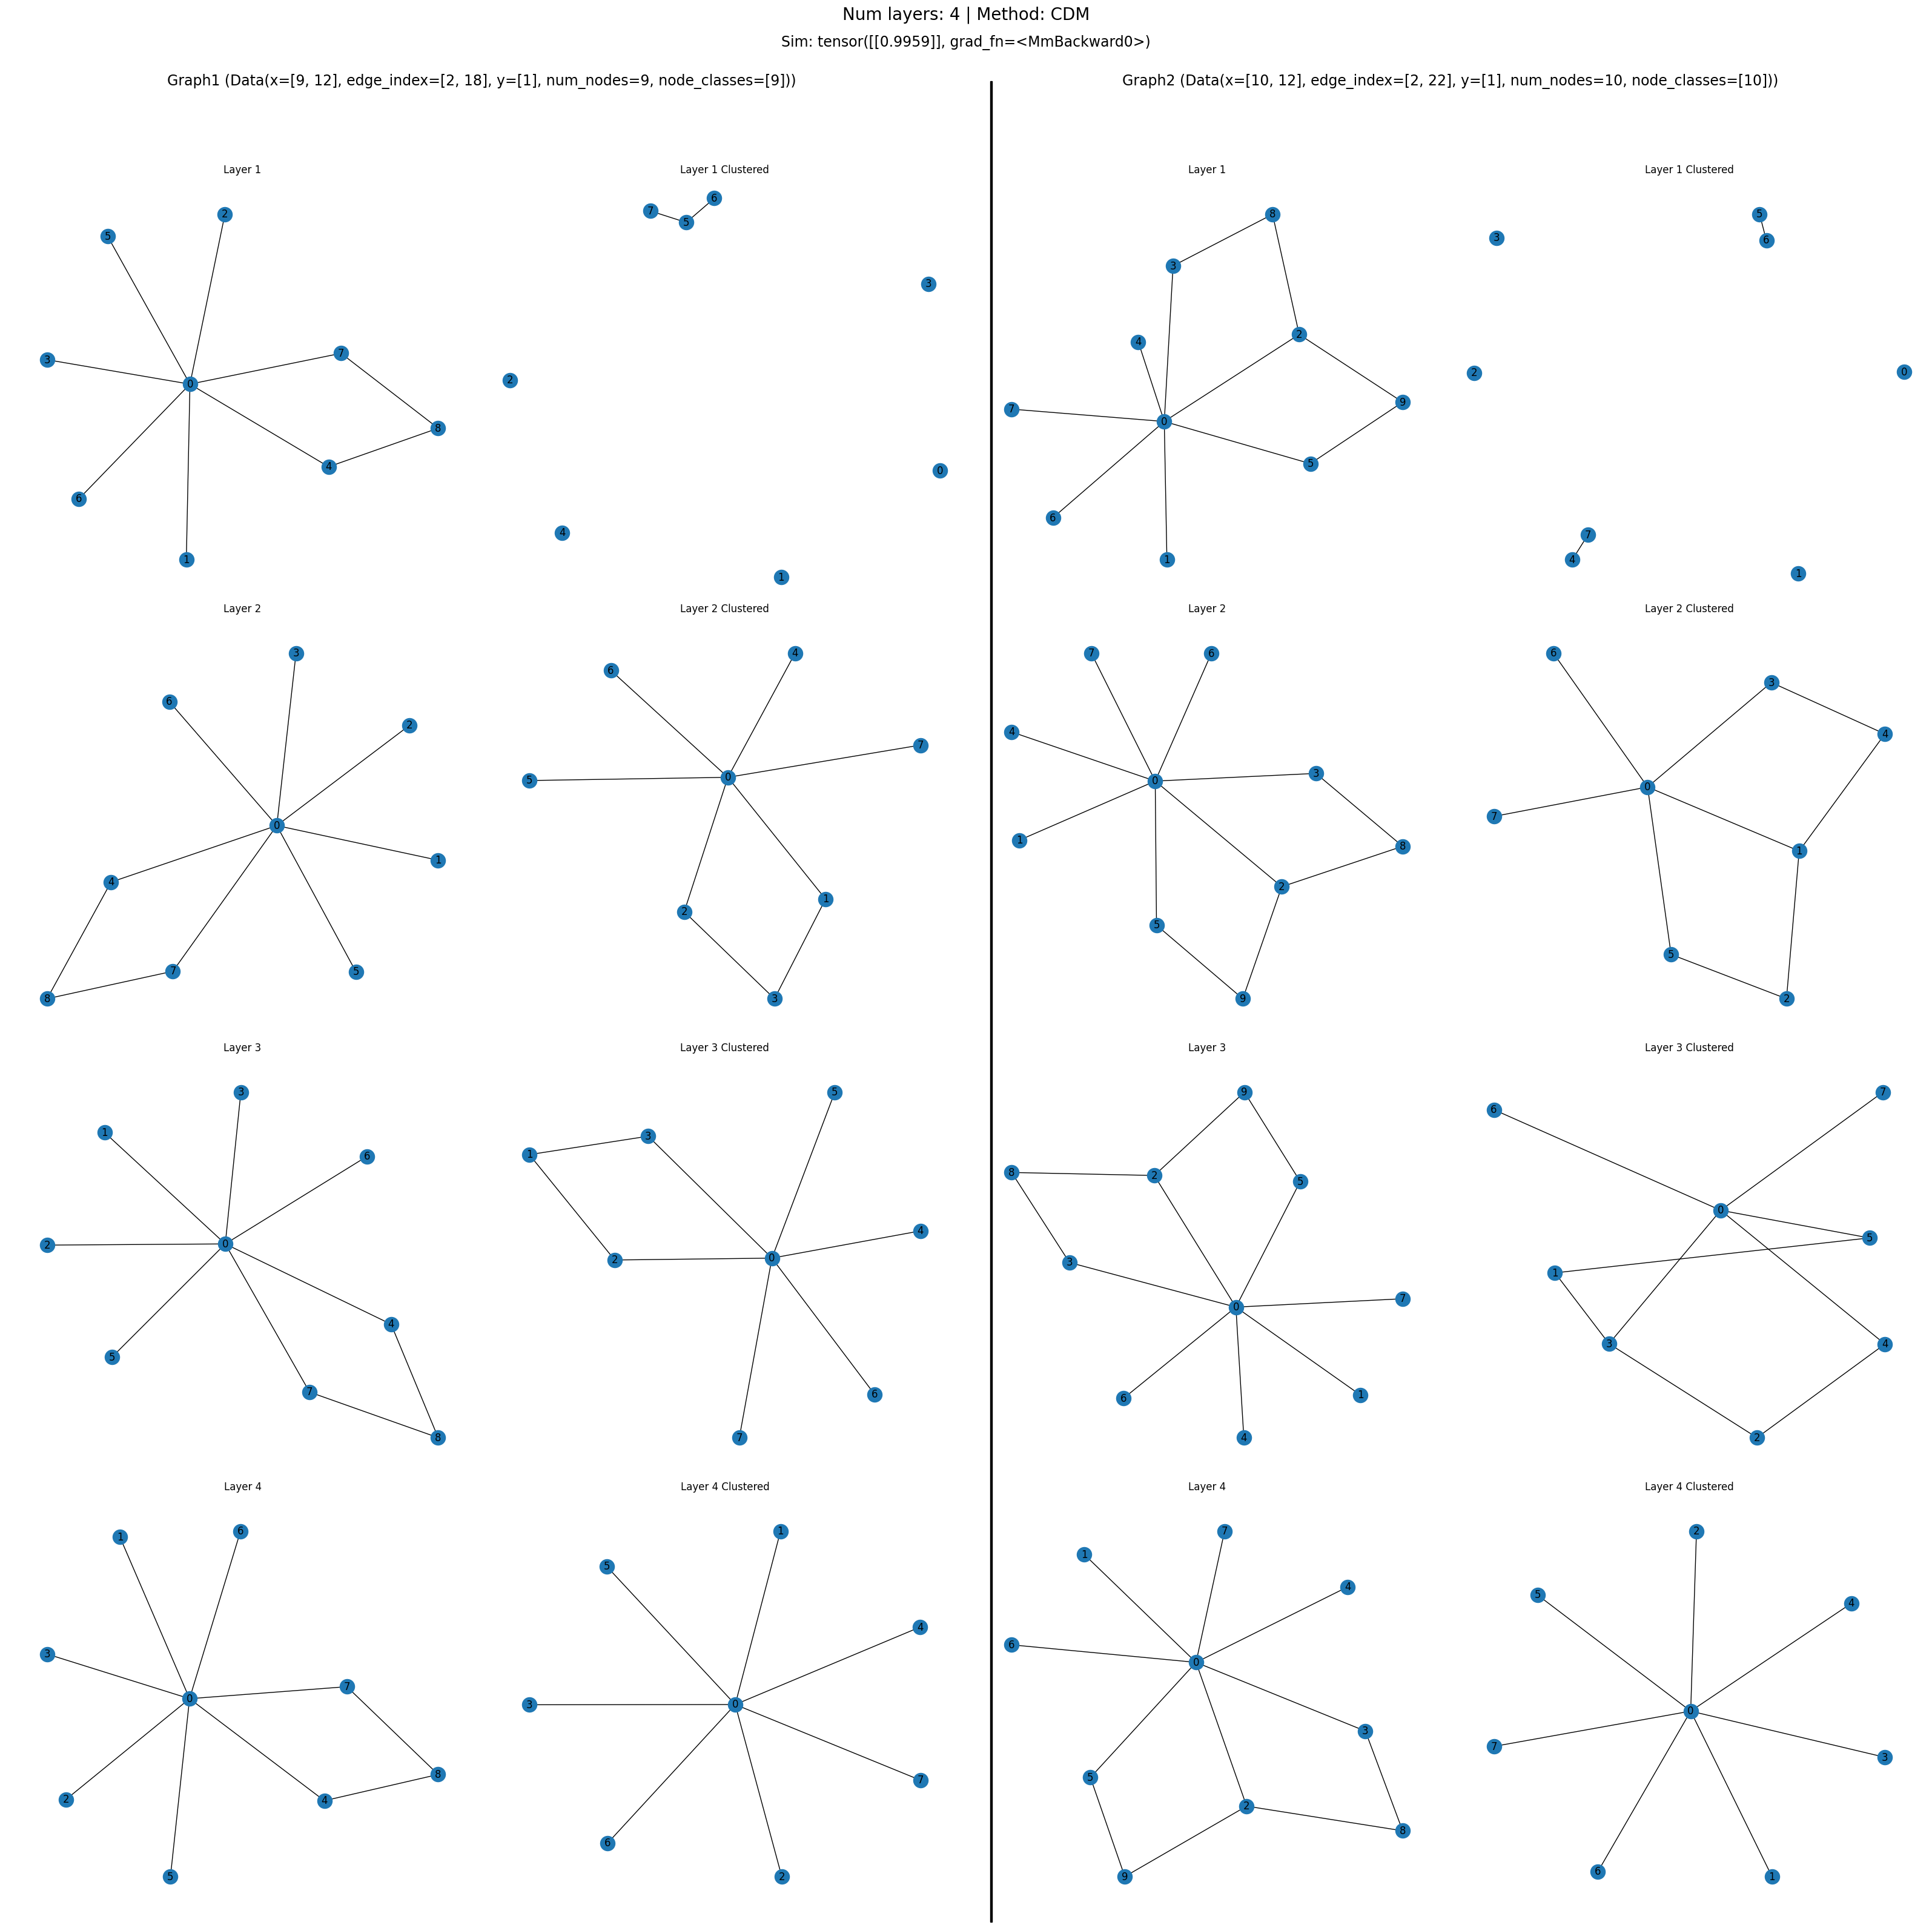

In [19]:
class1 = "class_3"
class2 = "class_3"
idx1 = random.sample(range(len(classes[class1])), 1)[0]
idx2 = random.sample(range(len(classes[class2])), 1)[0]
graph1, graph2 = classes[class1][idx1], classes[class2][idx2]

model.eval()

label = 1 if graph1.y == graph2.y else -1
print(f"Label: {label}")

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

sim = pairwise_cosine_similarity(emb1, emb2)
print(f"Similariy: {sim.item(): .4f}")

kmeans = KMeans(n_clusters=8, random_state=0)

g1_embeddings = torch.stack([t[0] for t in model.layer_outputs])
g2_embeddings = torch.stack([t[1] for t in model.layer_outputs])

mean_g1 = torch.mean(g1_embeddings, dim=0)
mean_g2 = torch.mean(g2_embeddings, dim=0)

clusters = []

for i in range(len(model.topk_outputs)):
    (
        (x_pooled_1, edge_index_pooled_1),
        (x_pooled_2, edge_index_pooled_2),
    ) = model.topk_outputs[i]
    clusters.append(
        (
            Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
            Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
        )
    )


title = f"Num layers: {args.num_layers} | Method: "

plot_graphs(
    [graph1.edge_index, graph2.edge_index],
    clusters,
    graph1,
    graph2,
    sim,
    title + "CDM",
    True,
)

In [9]:
def normalize_attention(a_x_s):
    a_min, a_max = a_x_s.min(), a_x_s.max()
    if a_max > a_min:
        return (a_x_s - a_min) / (a_max - a_min)
    return a_x_s


def visualize_graphs_with_attention(
    graph1, graph2, a_x_s, a_y_s, threshold=0.9, topk=None
):
    G1 = to_networkx(graph1, to_undirected=True)
    G2 = to_networkx(graph2, to_undirected=True)

    pos1 = nx.kamada_kawai_layout(G1)
    pos2 = nx.kamada_kawai_layout(G2)

    pos2_shifted = {k: [v[0] + 3, v[1]] for k, v in pos2.items()}

    plt.figure(figsize=(24, 14))
    nx.draw(
        G1, pos1, with_labels=True, node_color="skyblue", edge_color="k", node_size=700
    )
    nx.draw(
        G2,
        pos2_shifted,
        with_labels=True,
        node_color="lightcoral",
        edge_color="k",
        node_size=700,
    )

    combined_pos = {**pos1, **{k + len(G1): v for k, v in pos2_shifted.items()}}

    a_x_s = normalize_attention(a_x_s)
    a_y_s = normalize_attention(a_y_s).T

    def keep_topk(tensor, k):
        topk_values, topk_indices = torch.topk(tensor, k=k, dim=1)
        zero_tensor = torch.zeros_like(tensor)
        zero_tensor.scatter_(1, topk_indices, topk_values)

        return zero_tensor

    if topk:
        a_x_s = keep_topk(a_x_s, topk)
        a_y_s = keep_topk(a_y_s, topk)

    for i, j in torch.nonzero(a_x_s > threshold):
        src = i.item()
        target = j.item() + len(G1)
        weight = a_x_s[i, j].item()
        plt.plot(
            [combined_pos[src][0], combined_pos[target][0]],
            [combined_pos[src][1], combined_pos[target][1]],
            color="blue",
            alpha=min(weight * 5, 1.0),
            lw=weight * 2,
        )

    for i, j in torch.nonzero(a_y_s > threshold):
        src = i.item() + len(G1)
        target = j.item()
        weight = a_y_s[i, j].item()
        plt.plot(
            [combined_pos[src][0], combined_pos[target][0]],
            [combined_pos[src][1], combined_pos[target][1]],
            color="red",
            alpha=min(weight * 5, 1.0),
            lw=weight * 2,
        )

    plt.axis("off")
    plt.show()

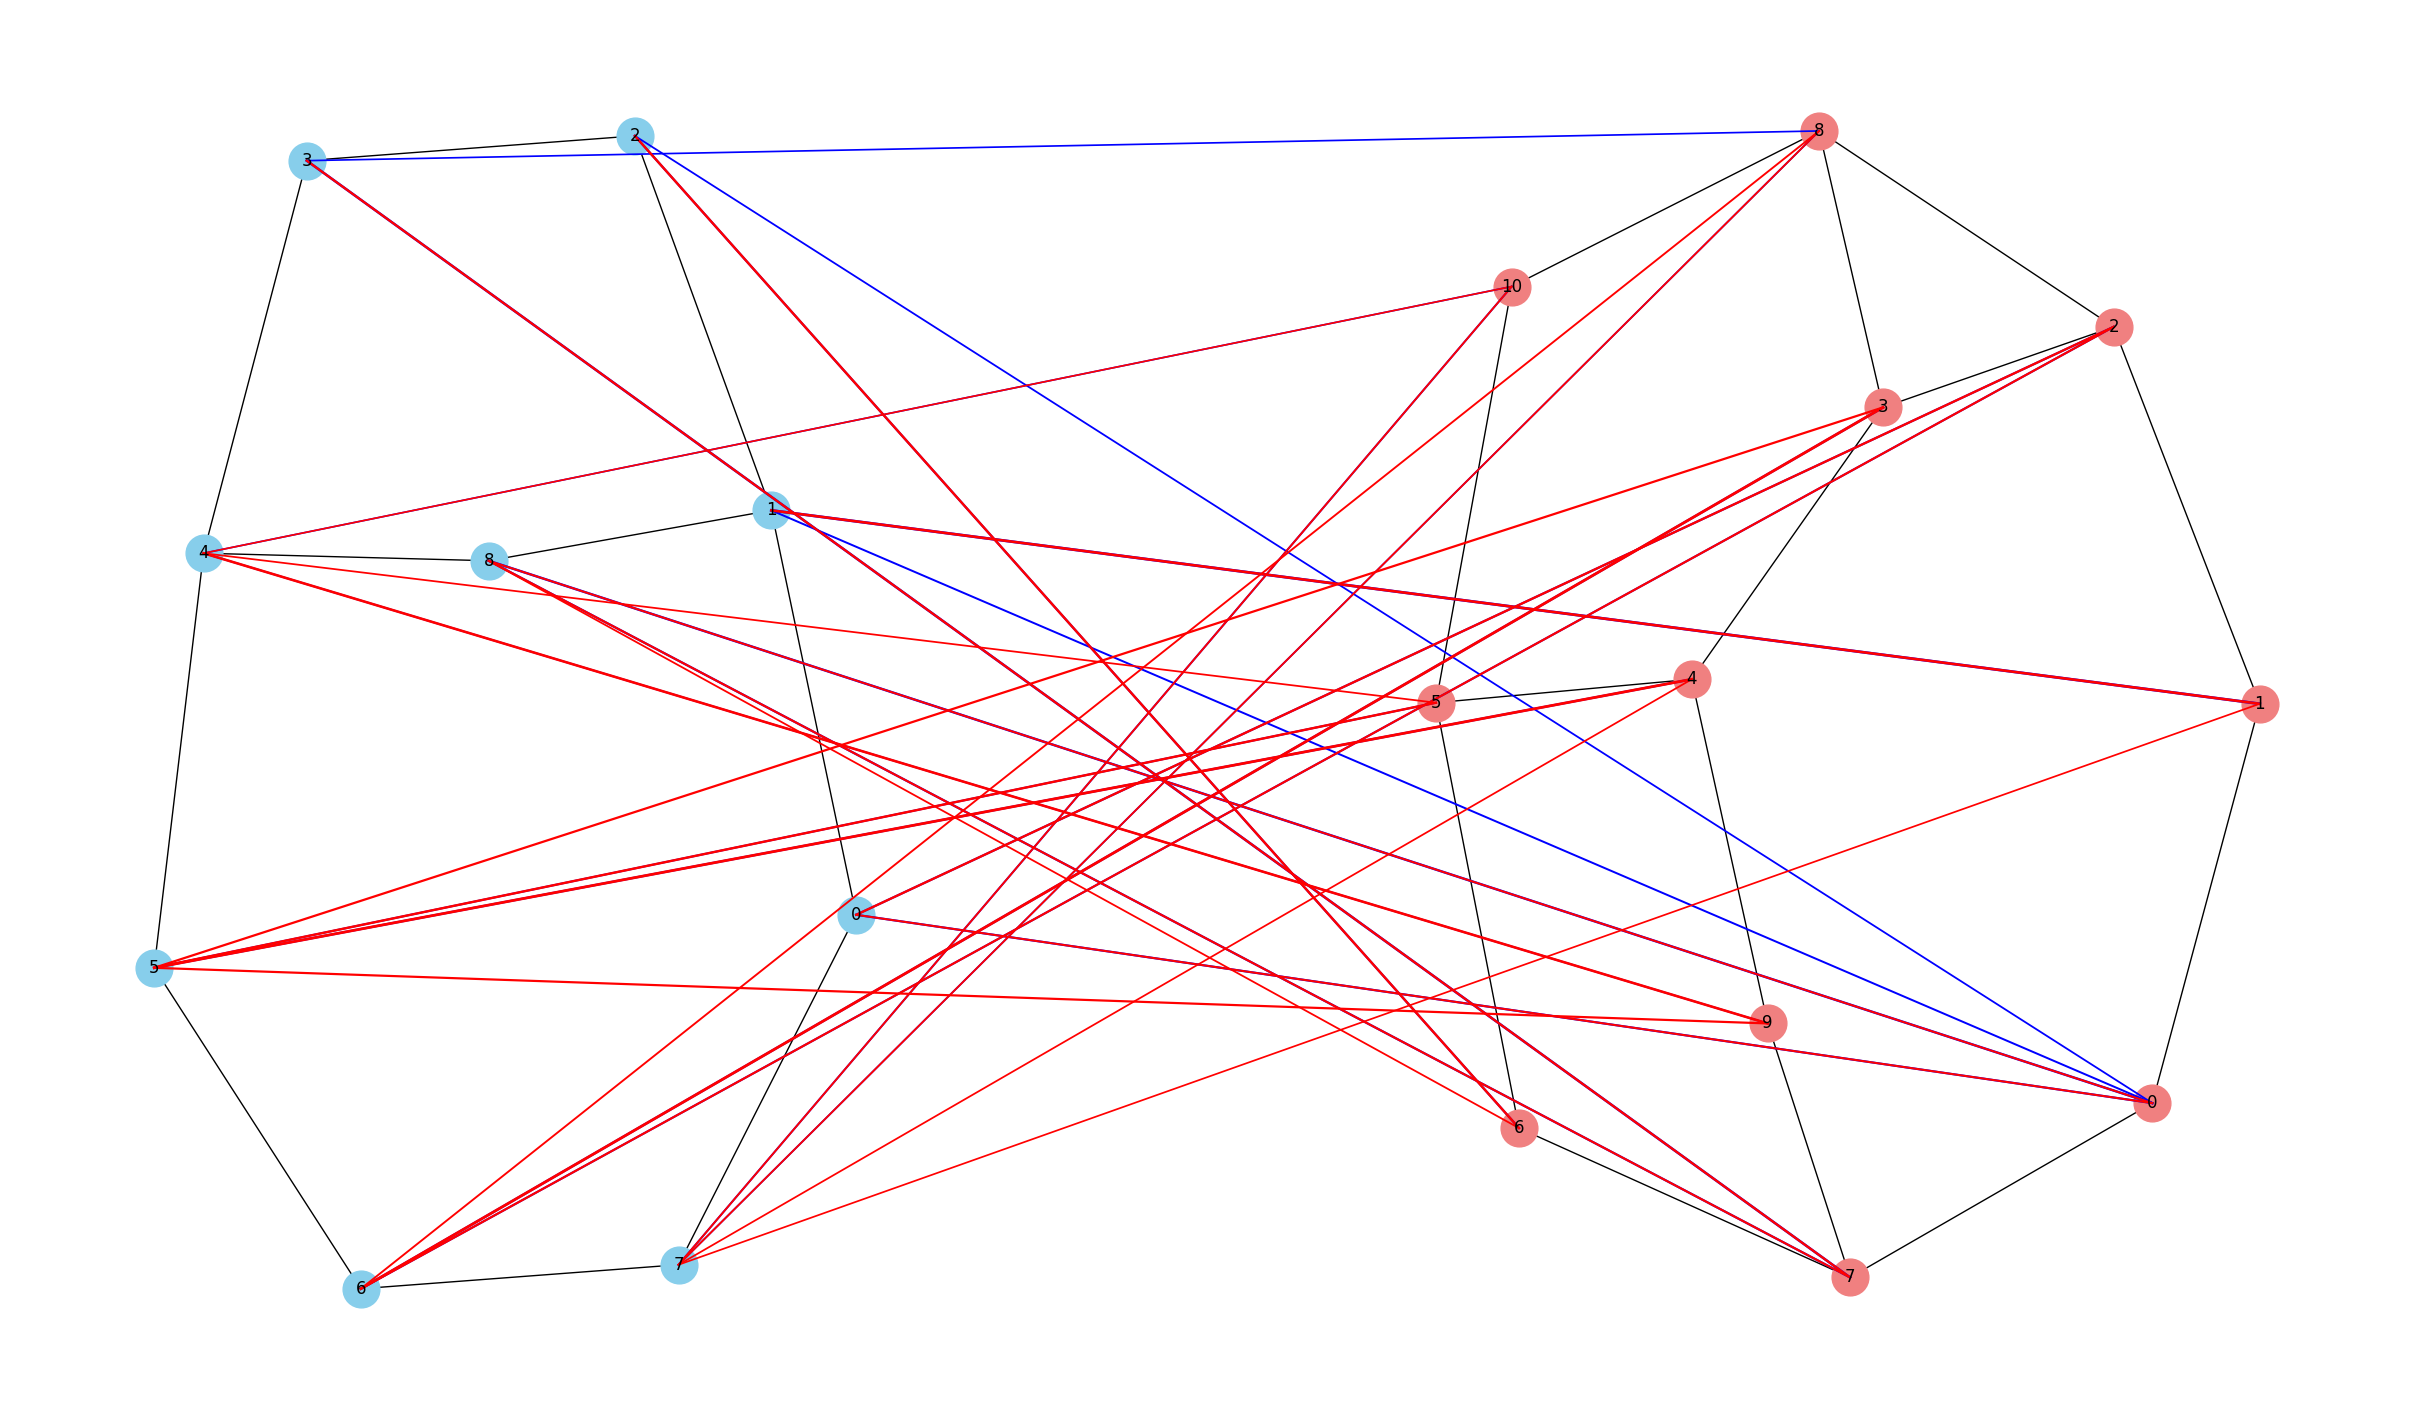

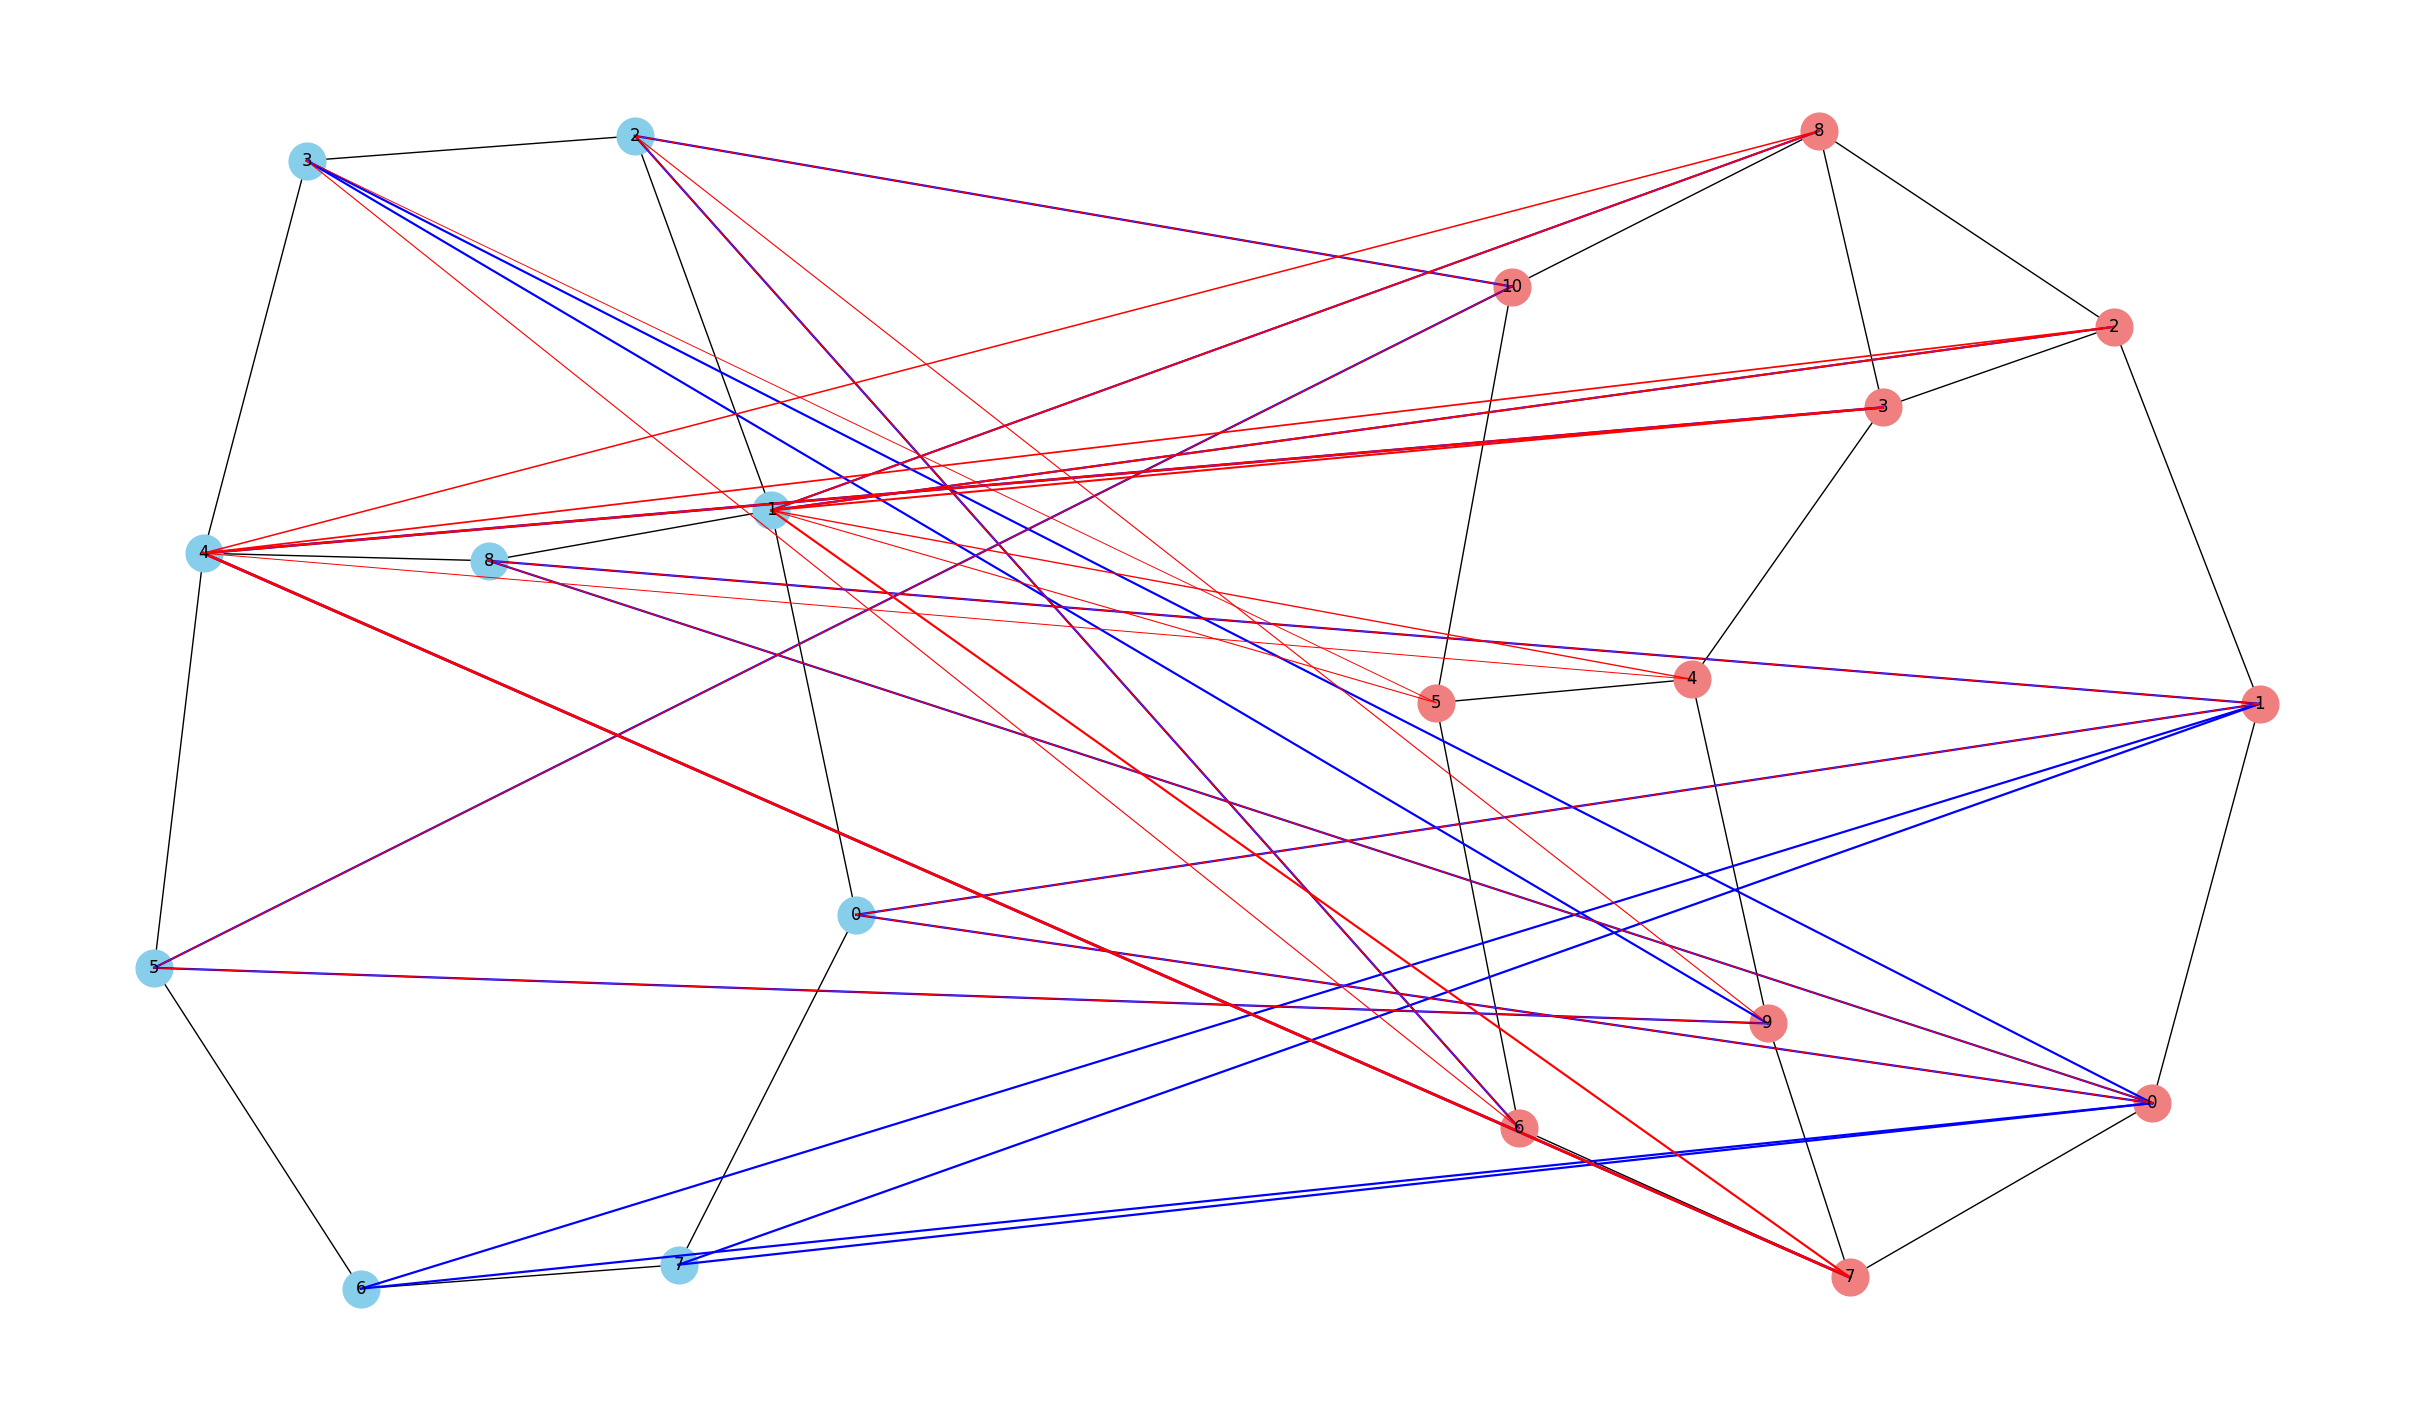

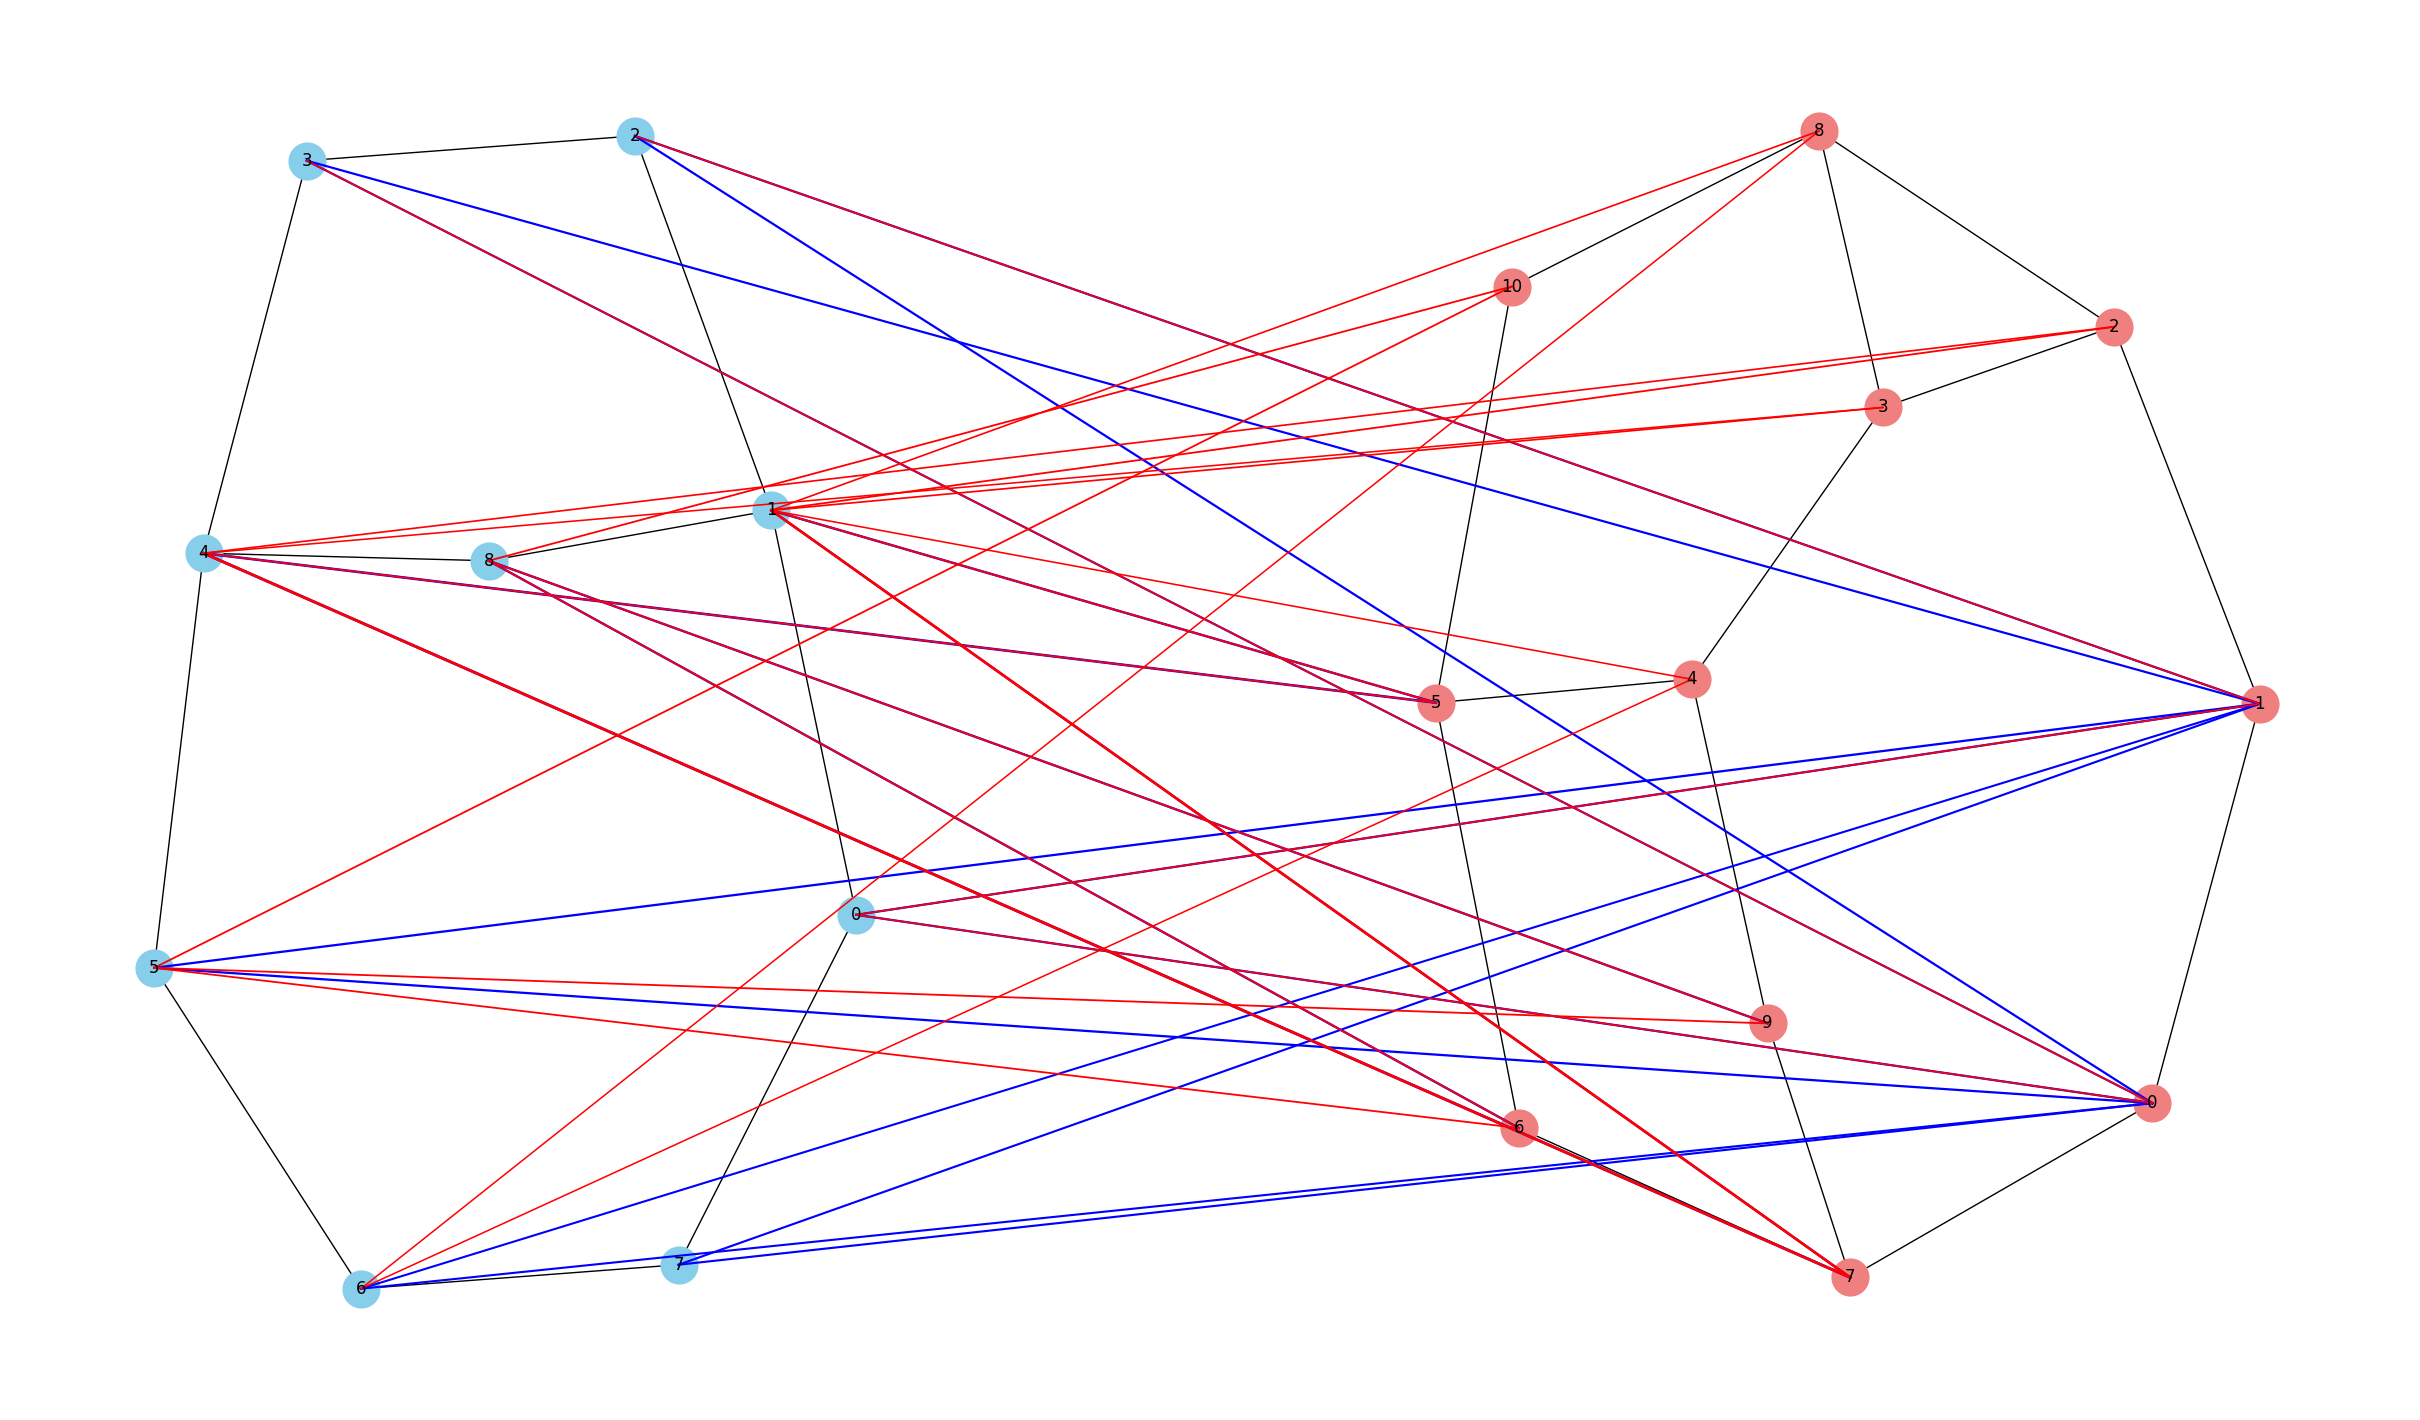

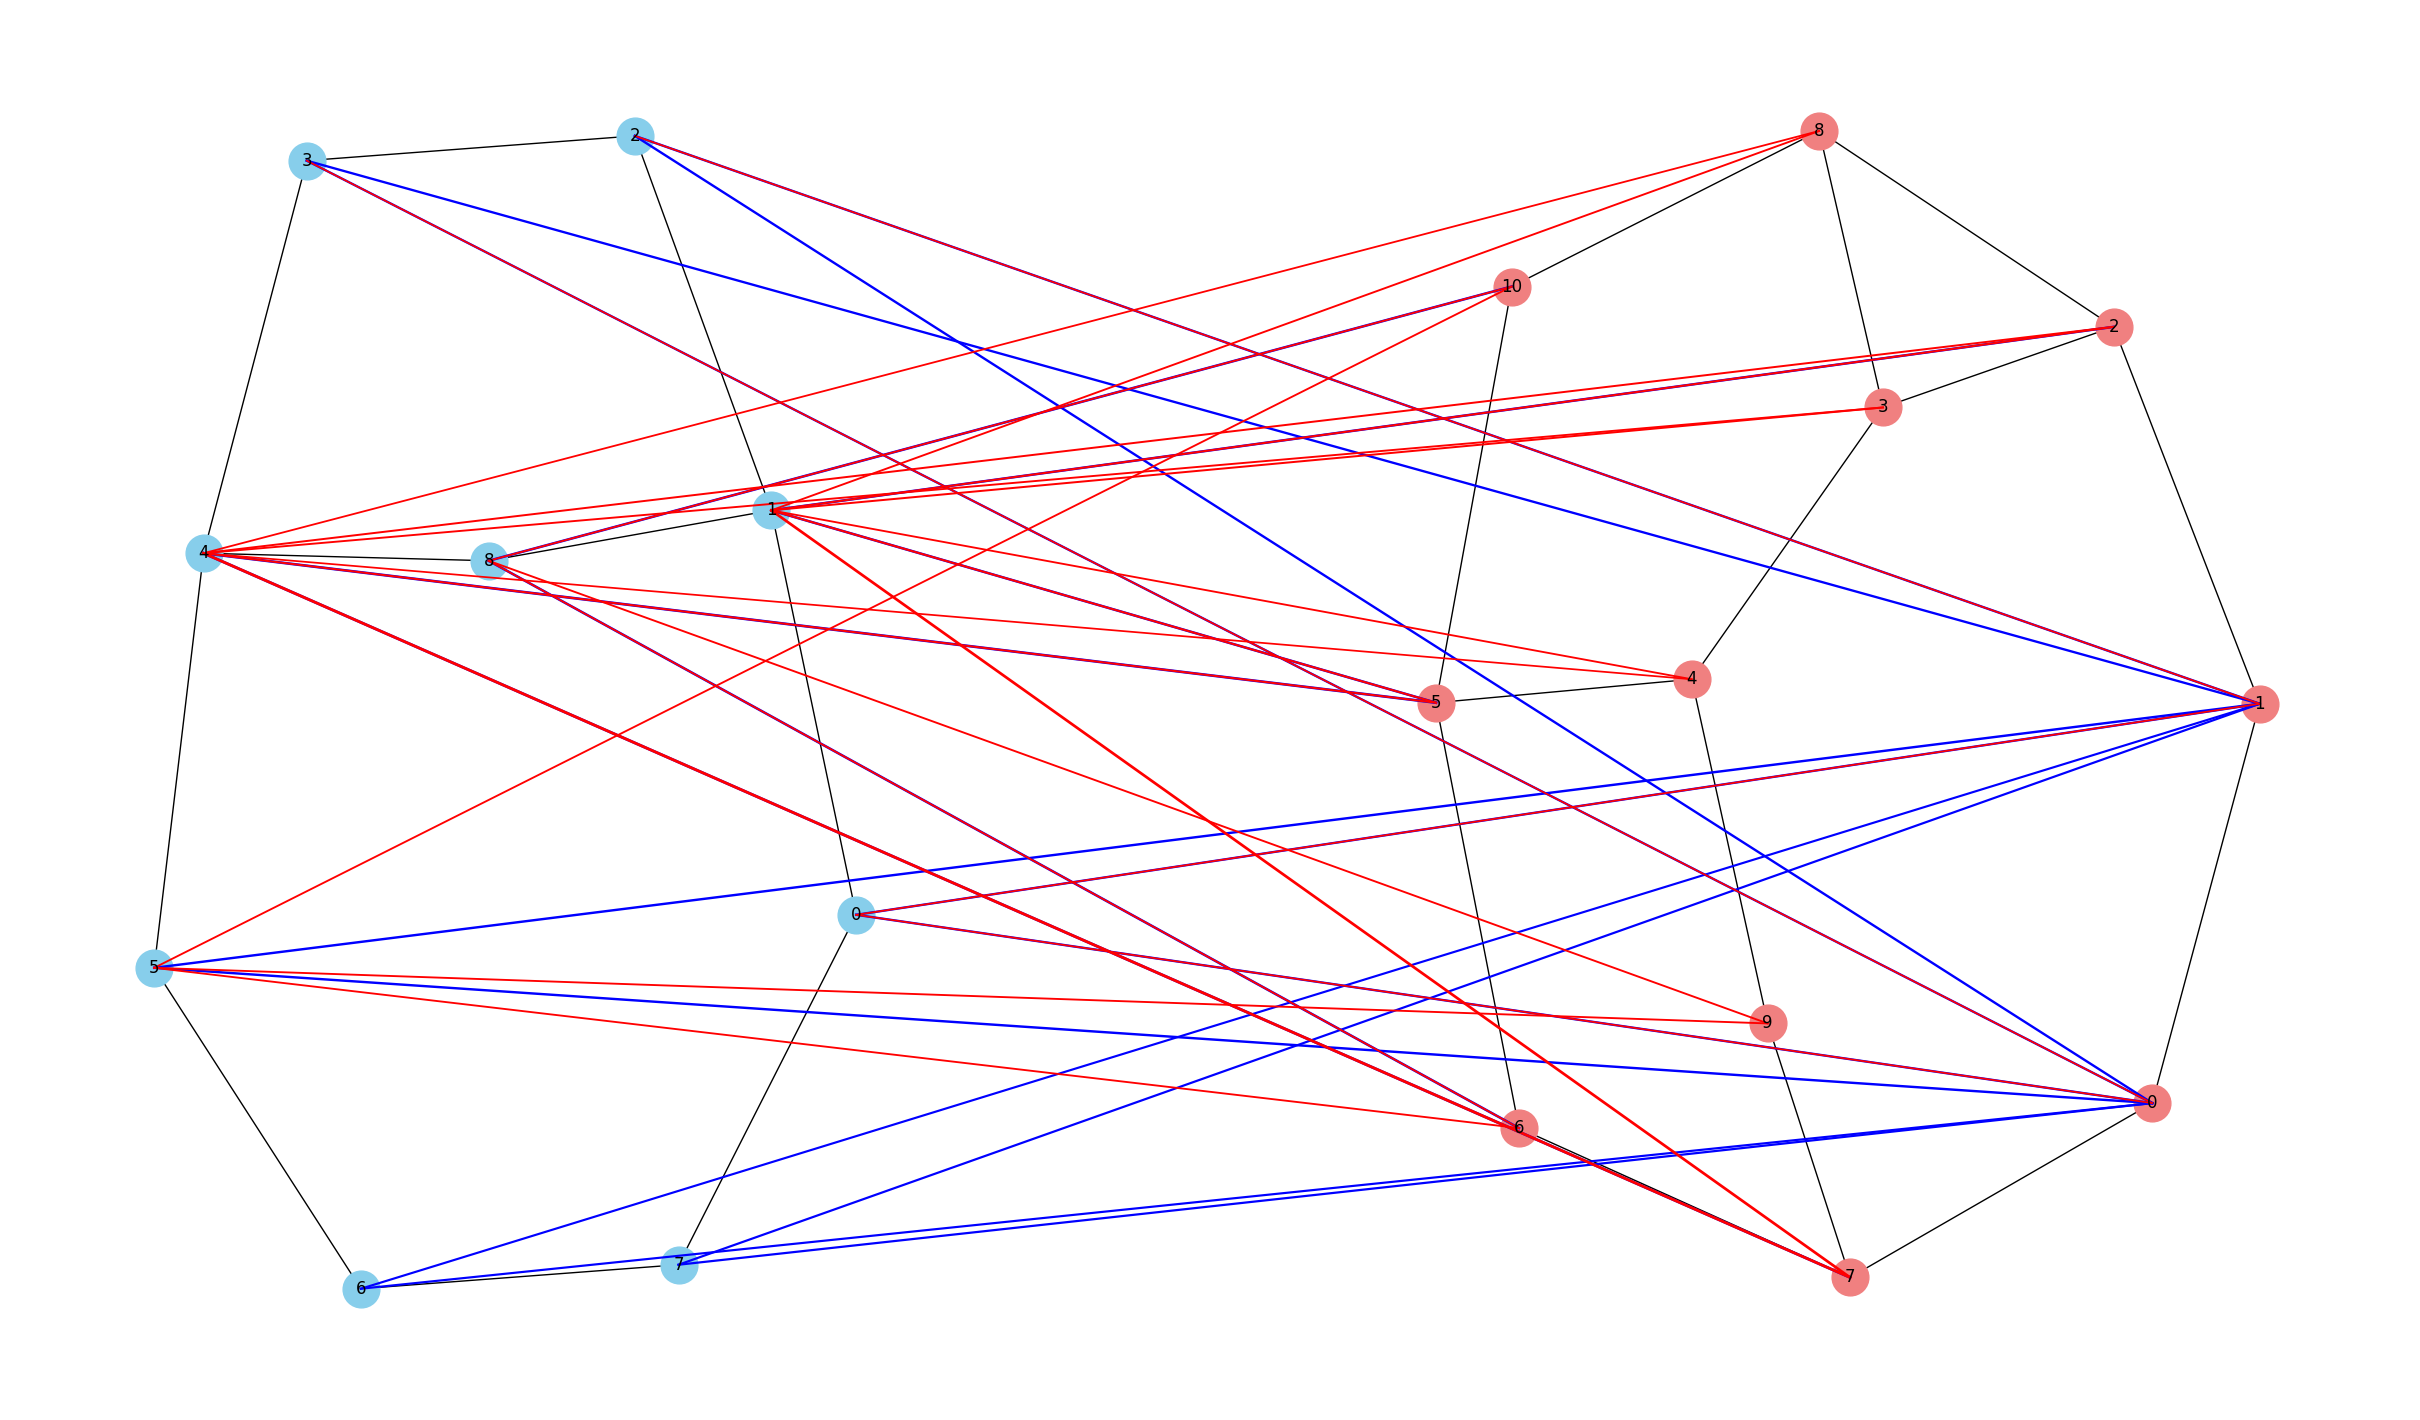

In [10]:
for i in range(len(model.layer_cross_attentions)):
    cross_attentions, a_x_s, a_y_s = model.layer_cross_attentions[i]
    visualize_graphs_with_attention(
        graph1, graph2, a_x_s[0], a_y_s[0], threshold=0.0, topk=2
    )